In [1]:
import pandas as pd
import numpy as np
import greek_accentuation.characters as gachar
import greek_accentuation.syllabify as gasyb
pd.set_option('display.max_columns', None)
import math
import nltk
from nltk.tokenize.regexp import WhitespaceTokenizer
import matplotlib.pyplot as plt
import scipy.stats as sp
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer


#repeating some of the work in the previous notebook, but counting diphthongs separately
#from single vowels.


In [2]:
df=pd.read_csv('dated_inscriptions.csv').drop('Unnamed: 0',axis=1)
testset=pd.read_csv('testset.csv')

In [3]:


#replacing non-vowels with whitespace. 
#eliminates stray english characters.

def remove_consonants(row):
    text= row['string']
    newtext=""
    vowel_count=0
    if text != None:
        for grkchar in text:
            if gasyb.is_vowel(grkchar):
                newtext=newtext+grkchar
                vowel_count=vowel_count+1
            else:
                newtext=newtext+" "
    return pd.Series([newtext,vowel_count])
sr=df.apply(remove_consonants, axis=1)
df['vowels']=sr[0]
df['vowel_count']=sr[1]
df.to_csv('vowels_only_from_inscriptions.csv') #stashing data for later use


In [4]:
#Tokenizing on whitespace rather than going char by char to preserve character clusters.
#Using jtauber's syllabify method to separate out likely diphthongs. 
#Counting as before.

counts={}
vowels_counted=[]

def get_vowel_counts(row):
    xml_filename=row['xml_filenames']
    greek=row['vowels']
    vcount={}
    tokens=nltk.word_tokenize(greek) #tokenize string on whitespace
    if tokens != None:
        for token in tokens:
            syllables=gasyb.syllabify(token) #separate vowel cluster into syllables if necessary
            for syllable in syllables:
                return_token=""
                for char in syllable: 
                    return_token=return_token+gachar.base(char).lower() #strip accents, put in lower case
                if return_token in vcount:
                    vcount[return_token]=vcount[return_token]+1
                else:
                    vcount[return_token]=1
                    if return_token not in vowels_counted:
                        vowels_counted.append(return_token)

    counts[xml_filename]=vcount
    
            
throwaway=df.apply(get_vowel_counts,axis=1) #throwaway prevents print to stdout

counts=pd.DataFrame.from_dict(counts)
counts=pd.DataFrame.transpose(counts)
counts=counts.fillna(0)
counts['charsum']=counts.sum(axis=1,numeric_only=True)
counts.to_csv('diphthong_and_vowel_counts.csv')

#converting to dataframe

In [5]:
df=df.set_index('xml_filenames').join(counts) #joining with original dataframe
df=df.reset_index()


#sorting samples into pools by date

def rounded_date(date):
    x=(math.floor((date + 50)/100))*100
    return x

df['date_notBefore_rounded']=df['date_notBefore'].apply(rounded_date)
df['date_notAfter_rounded']=df['date_notAfter'].apply(rounded_date)


#sorting the test data into the same pools for later use


testset['date_notBefore_rounded']=testset['date_notBefore'].apply(rounded_date)
testset['date_notAfter_rounded']=testset['date_notAfter'].apply(rounded_date)



In [6]:

#creating and stashing separate dataframes for earliest and latest date. summing chars.

nbdf=df.drop('date_notBefore',axis=1).drop('date_notAfter',axis=1).drop('date_notAfter_rounded',axis=1).drop('charsum',axis=1)
nbdf=nbdf.groupby('date_notBefore_rounded').sum()
nbdf=nbdf.reset_index()
nbdf.to_csv('vowelcounts_by_notBefore.csv')
nadf=df.drop('date_notBefore',axis=1).drop('date_notAfter',axis=1).drop('date_notBefore_rounded',axis=1).drop('charsum',axis=1)
nadf=nadf.groupby('date_notAfter_rounded').sum()
nadf=nadf.reset_index()
nadf.to_csv('vowelcounts_by_notAfter.csv')


#omitting buckets with small character counts. 

nadf=nadf[nadf['vowel_count']>500]
nbdf=nbdf[nbdf['vowel_count']>500]




Note that the y-axis is different on the left and right hand sides.
Vowel and diphthong counts are separated to avoid repeated line colour.


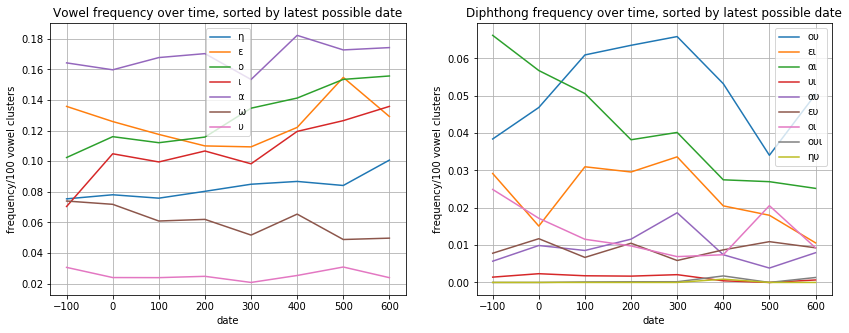

In [7]:
print('\n\nNote that the y-axis is different on the left and right hand sides.')
print('Vowel and diphthong counts are separated to avoid repeated line colour.')
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.grid(which='both')
for vowel in vowels_counted:
    if len(vowel)==1:
        plt.plot(nadf['date_notAfter_rounded'],nadf[vowel]/nadf['vowel_count'],label=vowel)
plt.legend()
plt.xlabel('date')
plt.ylabel('frequency/100 vowel clusters')
plt.title('Vowel frequency over time, sorted by latest possible date')

plt.subplot(1,2,2)
plt.grid(which='both')

for vowel in vowels_counted:
    if len(vowel)>1:
        plt.plot(nadf['date_notAfter_rounded'],nadf[vowel]/nadf['vowel_count'],label=vowel)
plt.legend()

plt.xlabel('date')
plt.ylabel('frequency/100 vowel clusters')
plt.title('Diphthong frequency over time, sorted by latest possible date')
plt.show()

In [8]:
nadf #the actual numbers

,date_notAfter_rounded,vowel_count,α,αι,αυ,ε,ει,ευ,η,ηυ,ι,ο,οι,ου,ουι,υ,υι,ω
1,-100,1406,231.0,93.0,8.0,191.0,41.0,11.0,106.0,0.0,99.0,144.0,35.0,54.0,0.0,43.0,2.0,104.0
2,0,3843,614.0,218.0,38.0,484.0,58.0,45.0,300.0,0.0,403.0,446.0,66.0,180.0,0.0,92.0,9.0,276.0
3,100,15664,2628.0,792.0,134.0,1841.0,485.0,105.0,1188.0,0.0,1559.0,1756.0,181.0,954.0,2.0,374.0,28.0,954.0
4,200,16572,2823.0,633.0,192.0,1823.0,490.0,174.0,1331.0,0.0,1768.0,1919.0,162.0,1052.0,3.0,410.0,28.0,1027.0
5,300,10559,1620.0,424.0,197.0,1155.0,355.0,62.0,897.0,0.0,1038.0,1422.0,73.0,695.0,2.0,219.0,22.0,546.0
6,400,2293,418.0,63.0,17.0,280.0,47.0,20.0,199.0,2.0,274.0,324.0,17.0,122.0,4.0,58.0,1.0,150.0
7,500,1557,269.0,42.0,6.0,241.0,28.0,17.0,131.0,0.0,197.0,239.0,32.0,53.0,0.0,48.0,0.0,76.0
8,600,1509,263.0,38.0,12.0,195.0,16.0,14.0,152.0,0.0,205.0,235.0,14.0,76.0,2.0,36.0,1.0,75.0


In [9]:
#the frequencies
nadf_percents=pd.DataFrame(nadf['date_notAfter_rounded'])
for vowel in vowels_counted:
    nadf_percents[vowel]=nadf[vowel]/nadf['vowel_count']
nadf_percents

,date_notAfter_rounded,η,ε,ο,ου,ει,ι,α,ω,αι,υ,υι,αυ,ευ,οι,ουι,ηυ
1,-100,0.075391,0.135846,0.102418,0.038407,0.029161,0.070413,0.164296,0.073969,0.066145,0.030583,0.001422,0.005690,0.007824,0.024893,0.000000,0.000000
2,0,0.078064,0.125943,0.116055,0.046838,0.015092,0.104866,0.159771,0.071819,0.056727,0.023940,0.002342,0.009888,0.011710,0.017174,0.000000,0.000000
3,100,0.075843,0.117531,0.112104,0.060904,0.030963,0.099528,0.167773,0.060904,0.050562,0.023876,0.001788,0.008555,0.006703,0.011555,0.000128,0.000000
4,200,0.080316,0.110005,0.115798,0.063481,0.029568,0.106686,0.170348,0.061972,0.038197,0.024741,0.001690,0.011586,0.010500,0.009776,0.000181,0.000000
5,300,0.084951,0.109385,0.134672,0.065821,0.033621,0.098305,0.153424,0.051709,0.040155,0.020741,0.002084,0.018657,0.005872,0.006914,0.000189,0.000000
6,400,0.086786,0.122111,0.141300,0.053205,0.020497,0.119494,0.182294,0.065416,0.027475,0.025294,0.000436,0.007414,0.008722,0.007414,0.001744,0.000872
7,500,0.084136,0.154785,0.153500,0.034040,0.017983,0.126525,0.172768,0.048812,0.026975,0.030829,0.000000,0.003854,0.010918,0.020552,0.000000,0.000000
8,600,0.100729,0.129225,0.155732,0.050364,0.010603,0.135852,0.174288,0.049702,0.025182,0.023857,0.000663,0.007952,0.009278,0.009278,0.001325,0.000000




Note that the y-axis is different on the right and left hand sides.
Vowel and diphthong counts are separated to avoid repeated line colour.


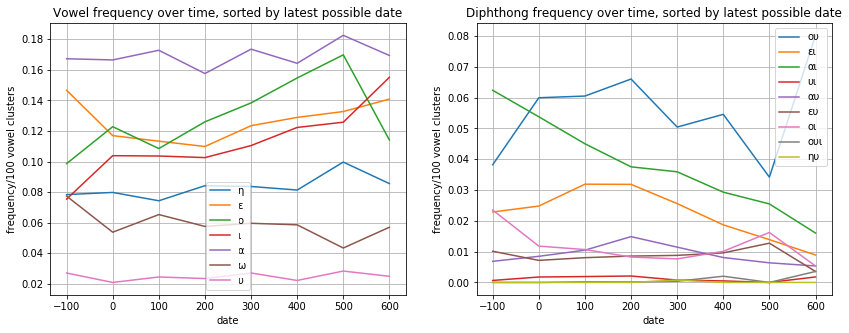

In [10]:
print('\n\nNote that the y-axis is different on the right and left hand sides.')
print('Vowel and diphthong counts are separated to avoid repeated line colour.')
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.grid(which='both')
for vowel in vowels_counted:
    if len(vowel)==1:
        plt.plot(nbdf['date_notBefore_rounded'],nbdf[vowel]/nbdf['vowel_count'],label=vowel)
plt.legend()
plt.xlabel('date')
plt.ylabel('frequency/100 vowel clusters')
plt.title('Vowel frequency over time, sorted by latest possible date')

plt.subplot(1,2,2)
plt.grid(which='both')

for vowel in vowels_counted:
    if len(vowel)>1:
        plt.plot(nbdf['date_notBefore_rounded'],nbdf[vowel]/nbdf['vowel_count'],label=vowel)
plt.legend()

plt.xlabel('date')
plt.ylabel('frequency/100 vowel clusters')
plt.title('Diphthong frequency over time, sorted by latest possible date')
plt.show()

In [11]:
nbdf #the actual numbers

,date_notBefore_rounded,vowel_count,α,αι,αυ,ε,ει,ευ,η,ηυ,ι,ο,οι,ου,ουι,υ,υι,ω
2,-100,3062,512.0,191.0,21.0,449.0,70.0,31.0,240.0,0.0,231.0,302.0,72.0,117.0,0.0,83.0,2.0,237.0
3,0,9073,1510.0,488.0,77.0,1061.0,225.0,65.0,724.0,0.0,942.0,1114.0,107.0,544.0,0.0,190.0,16.0,488.0
4,100,15172,2621.0,683.0,159.0,1719.0,484.0,122.0,1128.0,0.0,1572.0,1646.0,162.0,918.0,3.0,372.0,29.0,991.0
5,200,19157,3018.0,719.0,285.0,2104.0,610.0,164.0,1613.0,0.0,1965.0,2413.0,158.0,1265.0,3.0,450.0,40.0,1103.0
6,300,2617,454.0,94.0,30.0,323.0,67.0,23.0,219.0,2.0,289.0,362.0,20.0,132.0,1.0,71.0,2.0,156.0
7,400,1979,325.0,58.0,16.0,255.0,37.0,19.0,161.0,0.0,242.0,306.0,20.0,108.0,4.0,44.0,1.0,116.0
8,500,1726,315.0,44.0,11.0,229.0,24.0,22.0,172.0,0.0,217.0,293.0,28.0,59.0,0.0,49.0,0.0,75.0
9,600,561,95.0,9.0,3.0,79.0,5.0,2.0,48.0,0.0,87.0,64.0,3.0,45.0,2.0,14.0,1.0,32.0


In [12]:
#the frequencies
nbdf_percents=pd.DataFrame(nbdf['date_notBefore_rounded'])
for vowel in vowels_counted:
    nbdf_percents[vowel]=nbdf[vowel]/nbdf['vowel_count']
nbdf_percents

,date_notBefore_rounded,η,ε,ο,ου,ει,ι,α,ω,αι,υ,υι,αυ,ευ,οι,ουι,ηυ
2,-100,0.078380,0.146636,0.098628,0.038210,0.022861,0.075441,0.167211,0.077400,0.062378,0.027106,0.000653,0.006858,0.010124,0.023514,0.000000,0.000000
3,0,0.079797,0.116940,0.122782,0.059958,0.024799,0.103825,0.166428,0.053786,0.053786,0.020941,0.001763,0.008487,0.007164,0.011793,0.000000,0.000000
4,100,0.074347,0.113301,0.108489,0.060506,0.031901,0.103612,0.172752,0.065318,0.045017,0.024519,0.001911,0.010480,0.008041,0.010678,0.000198,0.000000
5,200,0.084199,0.109829,0.125959,0.066033,0.031842,0.102573,0.157540,0.057577,0.037532,0.023490,0.002088,0.014877,0.008561,0.008248,0.000157,0.000000
6,300,0.083684,0.123424,0.138326,0.050439,0.025602,0.110432,0.173481,0.059610,0.035919,0.027130,0.000764,0.011464,0.008789,0.007642,0.000382,0.000764
7,400,0.081354,0.128853,0.154624,0.054573,0.018696,0.122284,0.164224,0.058615,0.029308,0.022233,0.000505,0.008085,0.009601,0.010106,0.002021,0.000000
8,500,0.099652,0.132677,0.169757,0.034183,0.013905,0.125724,0.182503,0.043453,0.025492,0.028389,0.000000,0.006373,0.012746,0.016222,0.000000,0.000000
9,600,0.085561,0.140820,0.114082,0.080214,0.008913,0.155080,0.169340,0.057041,0.016043,0.024955,0.001783,0.005348,0.003565,0.005348,0.003565,0.000000


In [13]:

#randomly selecting one fifth of the test set

testset=testset.reset_index()
test=testset[testset['index']%5==0] 
test=test[['xml_filenames','date_notBefore_rounded','date_notAfter_rounded']]


In [14]:
#setting up the train set

X=df.drop('string',axis=1)
X=X.drop('vowels',axis=1)
X=X.drop('charsum',axis=1)
X=X.drop('vowel_count',axis=1)
X=X.drop('date_notBefore',axis=1)
X=X.drop('date_notAfter',axis=1)


#setting up the test set

test_filenames=test['xml_filenames'].as_matrix()
test=test[['xml_filenames']]
Xtestset=pd.merge(X, test, on='xml_filenames')


#removing the test set from the train set

for filename in test_filenames:
    X=X[X['xml_filenames']!=filename]


In [15]:
#extracting train and test sets and target values

ytest_na=Xtestset['date_notAfter_rounded'].as_matrix()
ytest_nb=Xtestset['date_notBefore_rounded'].as_matrix()
Xtest=Xtestset.drop('date_notAfter_rounded',axis=1).drop('date_notBefore_rounded',axis=1).drop('xml_filenames',axis=1).as_matrix()


ytrain_na=X['date_notAfter_rounded'].as_matrix()
ytrain_nb=X['date_notBefore_rounded'].as_matrix()
Xtrain=X.drop('date_notAfter_rounded',axis=1).drop('date_notBefore_rounded',axis=1).drop('xml_filenames',axis=1).as_matrix()


In [20]:
tf_transformer = TfidfTransformer(use_idf=False).fit(Xtrain)
Xtrain_tf=tf_transformer.transform(Xtrain)
Xtrain_tf.shape
clftfa=MultinomialNB()
clftfa.fit(Xtrain_tf,ytrain_na)
print('\npredicted date_notAfter:\n',clftfa.predict(Xtest))
print('\nactual date_notAfter:\n',ytest_na)
print('\nscore with model trained on date_notAfter: ',clftfa.score(Xtest,ytest_na))


predicted date_notAfter:
 [100 100 200 300 300 100 300 100 200 100 200 100 100 100 100 100]

actual date_notAfter:
 [200 200 100 300 300 300 200 100 200 100 100 100 100   0 200 200]

score with model trained on date_notAfter:  0.4375


In [22]:
clftfb=MultinomialNB()
clftfb.fit(Xtrain_tf,ytrain_nb)
print('\npredicted date_notBefore:\n',clftfb.predict(Xtest))
print('\nactual date_notBefore:\n',ytest_nb)
print('\nscore with model trained and tested on date_notBefore: ',clftfb.score(Xtest,ytest_nb))


predicted date_notBefore:
 [  0 200 200 200 200 200 200   0 500 200 100 200   0   0   0   0]

actual date_notBefore:
 [ 200  200    0  200  200  200  200    0  200    0  100  100  100 -100  200
  200]

score with model trained and tested on date_notBefore:  0.4375
